In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd

from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Activation
from keras.losses import categorical_crossentropy
from sklearn.metrics import accuracy_score
from keras.optimizers import Adam
from keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

import os
print(os.listdir("drive/MyDrive/datasets/expression3"))

['fer3.csv']


In [3]:
data = pd.read_csv("drive/MyDrive/datasets/expression3/fer3.csv")

emotion_map = {0: 'Happy', 1: 'Sleepy', 2: 'Singing', 3: 'Sad', 4: 'Neutral'}
emotion_counts = data['emotion'].value_counts(sort=False).reset_index()
emotion_counts.columns = ['emotion', 'number']
emotion_counts['emotion'] = emotion_counts['emotion'].map(emotion_map)

In [4]:
data.shape

(6056, 3)

In [5]:
data.head(5)

,emotion,pixels,usage
0,0,232 230 229 232 231 228 230 232 231 228 231 2...,training
1,0,210 207 206 209 209 207 209 209 208 209 209 2...,training
2,0,213 213 209 213 213 210 212 215 211 212 214 2...,training
3,0,215 216 216 215 215 216 217 215 216 217 215 2...,test
4,0,215 215 213 213 215 215 212 215 216 215 213 2...,training


In [6]:
data.usage.value_counts()

,count
usage,
training,3971
test,1189
validation,896


In [7]:
emotion_counts

,emotion,number
0,Happy,1073
1,Sleepy,1142
2,Singing,1194
3,Sad,1068
4,Neutral,1579


In [8]:
data = data.sample(frac=1)
data.head(5)

,emotion,pixels,usage
5401,4,149 159 165 155 151 142 131 122 112 107 100 1...,validation
3751,1,219 221 221 222 221 221 221 224 209 181 235 2...,training
1402,2,198 189 196 191 145 97 106 122 144 152 154 14...,training
4039,1,221 221 221 222 223 224 228 225 198 179 176 1...,training
880,4,225 236 245 250 253 254 253 255 255 254 239 2...,training


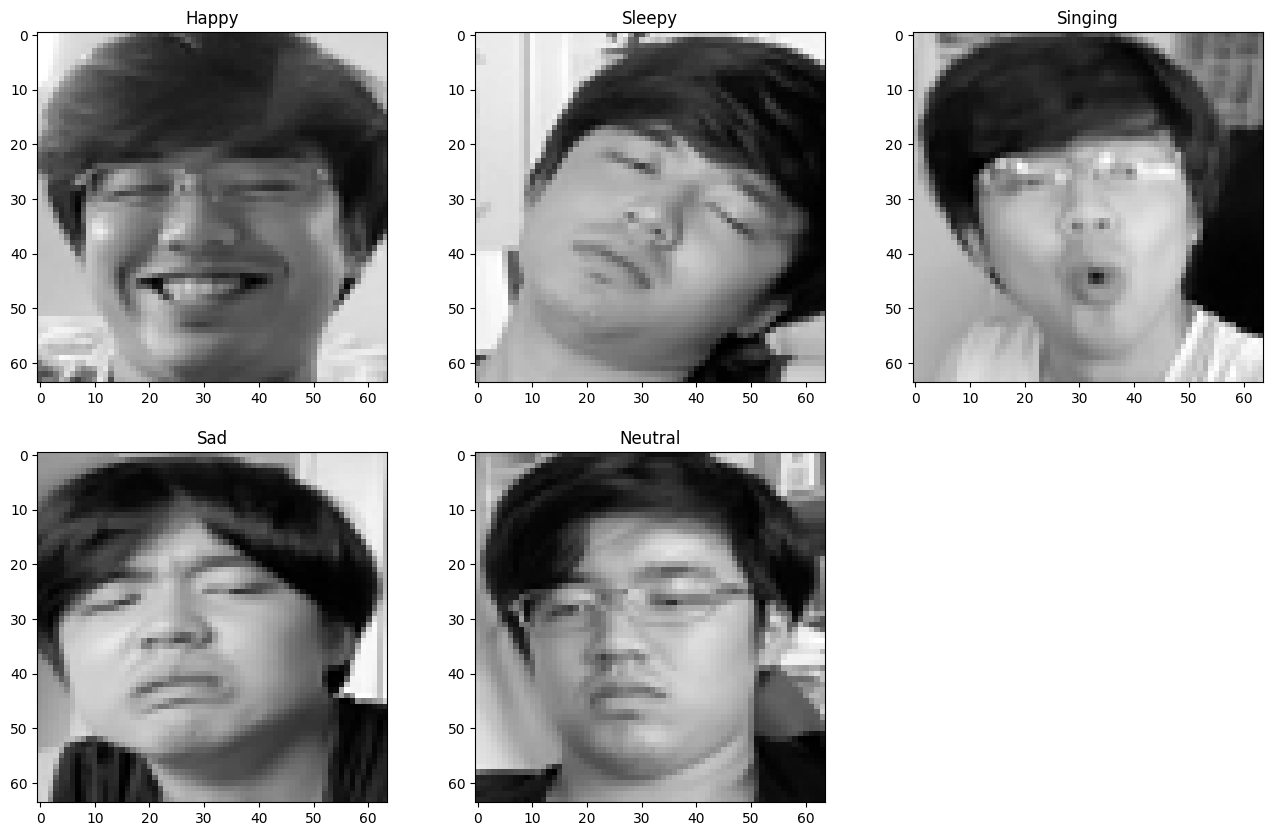

In [10]:
def row2image(row):
    pixels, emotion = row['pixels'], emotion_map[row['emotion']]
    img = np.array(pixels.split())
    img = img.reshape(64,64)
    return img.astype(np.uint8), emotion # Return grayscale image only

plt.figure(0, figsize=(16,10))
for i in range(1,6):
    face = data[data['emotion'] == i-1].iloc[0]
    img, emotion = row2image(face)  # Extract grayscale image and emotion
    plt.subplot(2,3,i)
    plt.imshow(img, cmap='gray')  # Display grayscale image
    plt.title(emotion)  # Set emotion as title

plt.show()

In [11]:
# Pre-processing data

# split data into training, validation, and test set
data_train = data[data['usage'] == ' training'].copy()
data_val = data[data['usage'] == ' validation'].copy()
data_test = data[data['usage'] == ' test'].copy()

print("train shape: {}, \nvalidation shape: {}, \ntest shape: {}".format(data_train.shape, data_val.shape, data_test.shape))

train shape: (3971, 3), 
validation shape: (896, 3), 
test shape: (1189, 3)


In [20]:
#initilize parameters
num_classes = 5
width, height = 64, 64
num_epochs = 100
batch_size = 32
num_features = 64

In [13]:
def CRNO(df, dataName):
    df['pixels'] = df['pixels'].apply(lambda pixel_sequence: [int(pixel) for pixel in pixel_sequence.split()])
    data_X = np.array(df['pixels'].tolist(), dtype='float32').reshape(-1,width, height,1)/255.0
    data_Y = to_categorical(df['emotion'], num_classes)
    print(dataName, "_X shape: {}, ", dataName, "_Y shape: {}".format(data_X.shape, data_Y.shape))
    return data_X, data_Y


train_X, train_Y = CRNO(data_train, "train") #training data
val_X, val_Y = CRNO(data_val, "val") #validation data
test_X, test_Y = CRNO(data_test, "test") #test data

train _X shape: {},  train _Y shape: (3971, 64, 64, 1)
val _X shape: {},  val _Y shape: (896, 64, 64, 1)
test _X shape: {},  test _Y shape: (1189, 64, 64, 1)


In [21]:
# Building CNN Model

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the model
model = Sequential()

# Module 1
model.add(Conv2D(2 * 2 * num_features, kernel_size=(3, 3), input_shape=(width, height, 1), data_format='channels_last'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(2 * 2 * num_features, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

# Module 2
model.add(Conv2D(2 * num_features, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(2 * num_features, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

# Module 3
model.add(Conv2D(num_features, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(num_features, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

# Flatten
model.add(Flatten())

# Dense layers
model.add(Dense(2 * 2 * 2 * 2 * num_features))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(2 * 2 * 2 * num_features))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(2 * 2 * num_features))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(2 * num_features))
model.add(BatchNormalization())
model.add(Activation('relu'))

# Output layer
model.add(Dense(num_classes, activation='softmax'))

# Compile model

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

# Data augmentation
data_generator = ImageDataGenerator(
    featurewise_center = False,
    featurewise_std_normalization = False,
    rotation_range = 10,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    zoom_range = .1,
    horizontal_flip = True,
    vertical_flip = True
)

# Training the model
history = model.fit(data_generator.flow(train_X, train_Y, batch_size=batch_size),
                              steps_per_epoch = len(train_X) // batch_size,
                              epochs = num_epochs,
                              verbose = 2,
                              validation_data = (val_X, val_Y)
)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)                   │ (None, 62, 62, 256)         │           2,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_20               │ (None, 62, 62, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_20 (Activation)           │ (None, 62, 62, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 62, 62, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_21               │ (None, 62, 62, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_21 (Activation)           │ (None, 62, 62, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 31, 31, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 31, 31, 128)         │         295,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_22               │ (None, 31, 31, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_22 (Activation)           │ (None, 31, 31, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 31, 31, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_23               │ (None, 31, 31, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_23 (Activation)           │ (None, 31, 31, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 15, 15, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_16 (Conv2D)                   │ (None, 15, 15, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_24               │ (None, 15, 15, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_24 (Activation)           │ (None, 15, 15, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 15, 15, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_25               │ (None, 15, 15, 64)          │             2

 Total params: 5,059,205 (19.30 MB)

 Trainable params: 5,053,573 (19.28 MB)

 Non-trainable params: 5,632 (22.00 KB)

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


124/124 - 45s - 362ms/step - accuracy: 0.3656 - loss: 1.5243 - val_accuracy: 0.1931 - val_loss: 8.0241
Epoch 2/100


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


124/124 - 1s - 11ms/step - accuracy: 0.4062 - loss: 1.3934 - val_accuracy: 0.1931 - val_loss: 8.8827
Epoch 3/100
124/124 - 13s - 102ms/step - accuracy: 0.4491 - loss: 1.3456 - val_accuracy: 0.1931 - val_loss: 5.5786
Epoch 4/100
124/124 - 1s - 11ms/step - accuracy: 0.4062 - loss: 1.3926 - val_accuracy: 0.1931 - val_loss: 5.7410
Epoch 5/100
124/124 - 19s - 152ms/step - accuracy: 0.4857 - loss: 1.2601 - val_accuracy: 0.1674 - val_loss: 3.8195
Epoch 6/100
124/124 - 1s - 9ms/step - accuracy: 0.5938 - loss: 1.0266 - val_accuracy: 0.1819 - val_loss: 3.7142
Epoch 7/100
124/124 - 13s - 102ms/step - accuracy: 0.5136 - loss: 1.2211 - val_accuracy: 0.2935 - val_loss: 2.1557
Epoch 8/100
124/124 - 1s - 9ms/step - accuracy: 0.5000 - loss: 1.2285 - val_accuracy: 0.2969 - val_loss: 2.1353
Epoch 9/100
124/124 - 20s - 160ms/step - accuracy: 0.5349 - loss: 1.1595 - val_accuracy: 0.3025 - val_loss: 2.6264
Epoch 10/100
124/124 - 1s - 11ms/step - accuracy: 0.5000 - loss: 1.0705 - val_accuracy: 0.2913 - val_l

In [23]:
model.save('drive/MyDrive/emotion3.keras')

In [24]:
from tensorflow import keras
saved_model = keras.models.load_model('drive/MyDrive/emotion3.keras')

In [25]:
test_true = np.argmax(test_Y, axis=1)
test_pred = np.argmax(saved_model.predict(test_X), axis=1)
print("CNN Model Accuracy on test set: {:.4f}".format(accuracy_score(test_true, test_pred)))

38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 100ms/step
CNN Model Accuracy on test set: 0.8133


# 以下、テスト

In [ ]:
type(test_X[100])

numpy.ndarray

In [ ]:
np.shape(test_X[0])

(48, 48, 1)

In [ ]:
test_Y[100]

array([0., 1., 0., 0., 0.])

In [ ]:
saved_model(test_X[100].reshape(1,48,48,1))

<tf.Tensor: shape=(1, 5), dtype=float32, numpy=
array([[0.00814541, 0.389442  , 0.2911916 , 0.30924937, 0.00197163]],
      dtype=float32)>

In [ ]:
display(test_X[100])

NameError: name 'test_X' is not defined